In [1]:
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend
import pandas as pd
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    GridSearchCV,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.linear_model import (
    LassoCV, 
    LinearRegression
) 
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    ExtraTreesRegressor, 
    StackingRegressor,
    VotingRegressor
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

In [2]:
data = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Project\used\train_2015.csv')
data['month'] = pd.to_datetime(data['month'])
data['month'] = pd.Categorical(data['month']).codes ## month-1 = 2015-01-01, month-71 = 2020-12-01

for feature in ['storey_range']:
    data[feature] = pd.Categorical(data[feature]).codes

data = data.sort_values(by='month').reset_index(drop=True)
data

,month,storey_range,floor_area_sqm,remaining_lease,MRT_distance,Mall_distance,Market_distance,Hawker_distance,CBD_distance,flat_type_1 ROOM,...,district_18,district_19,district_20,district_21,district_22,district_23,district_25,district_27,district_28,target
0,0,0,88.0,84,0.994266,0.808769,0.047046,0.185346,6.376045,0,...,0,0,1,0,0,0,0,0,0,259120.206490
1,0,2,123.0,84,0.549187,0.419358,0.356392,0.918559,13.832137,0,...,1,0,0,0,0,0,0,0,0,308259.587021
2,0,2,110.0,86,0.508942,0.561953,0.063419,0.752709,13.939894,0,...,1,0,0,0,0,0,0,0,0,306047.197640
3,0,1,110.0,87,0.222883,0.691542,0.579752,0.487156,12.733611,0,...,1,0,0,0,0,0,0,0,0,303834.808260
4,0,1,110.0,87,0.593777,0.622576,0.111711,1.128803,12.386175,0,...,1,0,0,0,0,0,0,0,0,293510.324484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122846,71,1,124.0,78,0.447200,0.450616,0.456106,1.457078,14.385243,0,...,1,0,0,0,0,0,0,0,0,343953.656770
122847,71,1,91.0,81,0.766830,0.757231,0.061727,0.724389,10.729444,0,...,0,0,0,0,0,1,0,0,0,262853.005069
122848,71,1,111.0,81,0.766830,0.757231,0.061727,0.724389,10.729444,0,...,0,0,0,0,0,1,0,0,0,293265.749457
122849,71,0,110.0,86,1.442513,1.329439,0.526374,2.202068,13.451268,0,...,0,0,0,0,0,0,0,1,0,383779.869660


In [3]:
print('Standard Deviation')
for flat_type in data.columns[data.columns.str.contains('flat_type_')]:
    print('{}: {}'.format(flat_type[10:],data[data[flat_type]==1]['target'].std().round(2)))
print("All types:", data['target'].std().round(2))

Standard Deviation
1 ROOM: 13705.59
2 ROOM: 26685.03
3 ROOM: 49847.88
4 ROOM: 86132.64
5 ROOM: 107020.99
EXECUTIVE: 85235.51
JUMBO: 103740.07
MULTI-GENERATION: 62650.9
TERRACE: 64201.66
All types: 111558.39


In [4]:
# plt.figure(figsize=(10,15))
# for i, feature in enumerate(['floor_area_sqm', 'remaining_lease', 'MRT_distance', 'Mall_distance', 'Hawker_distance', 'CBD_distance', 'target']):
#     plt.subplot(4, 2, i+1)
#     sns.scatterplot(x=data['month'], y=data[feature])
# plt.show()

# Data windowing

Important to split by the months, do not want contamination through the months.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [5]:
data = data.set_index('month')
X = data.drop('target', axis=1)
y = np.log1p(data['target'])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42)

X_test = X_test.reset_index()
y_test = y_test.reset_index(drop=True)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

X shape: (61425, 40)
X_test shape: (61426, 41)


In [6]:
def model_training(algorithm):
    i = 0
    scores = []
    n_splits = 10
    print('Training start...')

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(X, y):
        i += 1   
        X_train = X.iloc[train_idx, :].reset_index()
        X_val = X.iloc[val_idx, :].reset_index()
        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        y_true_test = y_test

        # for feature in ['floor_area_sqm', 'remaining_lease']:
        #     scaler = MinMaxScaler().fit(X_train[[feature]])
        #     X_train[feature] = scaler.transform(X_train[[feature]])
        #     X_val[feature] = scaler.transform(X_val[[feature]])
        #     X_test[feature] = scaler.transform(X_test[[feature]])

        start_time = time.time()

        with parallel_backend('threading'):
            model = algorithm.fit(X_train, y_train)

        end_time = time.time()

        y_pred_train = np.log1p(model.predict(X_train))
        y_pred_val = np.log1p(model.predict(X_val))
        y_pred_test = np.log1p(model.predict(X_test))

        train_rmse = np.exp(mean_squared_error(y_train, y_pred_train, squared=False)).round(4)
        val_rmse = np.exp(mean_squared_error(y_val, y_pred_val, squared=False)).round(4)
        test_rmse = np.exp(mean_squared_error(y_true_test, y_pred_test, squared=False)).round(4)

        time_elapsed = round(end_time-start_time, 3)
        print(f"Fold {i}: Train RMSE = {train_rmse}, Val RMSE = {val_rmse}, Test RMSE = {test_rmse} Time elapsed = {time_elapsed}s")
        scores.append([train_rmse, val_rmse, test_rmse])
        
    scores = pd.DataFrame(scores, columns=['train_rmse', 'val_rmse', 'test_rmse'])

    plt.figure(figsize=(10,5))
    sns.lineplot(x=scores.index, y=scores['train_rmse'], label='train_rmse')
    sns.lineplot(x=scores.index, y=scores['val_rmse'], label='val_rmse')
    sns.lineplot(x=scores.index, y=scores['test_rmse'], label='test_rmse')
    plt.xticks(range(n_splits))
    plt.xlabel('folds'); plt.ylabel('scores')
    plt.show()
    return model

def test_flat_types(model):
    for flat_type in data.columns[data.columns.str.contains('flat_type_')]:
        X_test_1 = X_test[X_test[flat_type]==1]
        y_test_1 = y_test[X_test[flat_type]==1]

        y_pred_test = np.log1p(model.predict(X_test_1))

        test_rmse = np.exp(mean_squared_error(y_test_1, y_pred_test, squared=False)).round(4)
        print(f'{flat_type[10:]}: No. of samples = {X_test_1.shape[0]}, RMSE = {test_rmse}, Z-score = {(test_rmse/np.exp(y_test_1).std()).round(2)}')

Training start...
Fold 1: Train RMSE = 22661.1871, Val RMSE = 22599.6435, Test RMSE = 23310.7067 Time elapsed = 0.01s
Fold 2: Train RMSE = 22631.558, Val RMSE = 22908.5549, Test RMSE = 23435.8249 Time elapsed = 0.015s
Fold 3: Train RMSE = 22716.7193, Val RMSE = 22932.7955, Test RMSE = 23312.9351 Time elapsed = 0.022s
Fold 4: Train RMSE = 22769.6051, Val RMSE = 23034.6466, Test RMSE = 23312.4508 Time elapsed = 0.026s
Fold 5: Train RMSE = 22820.2547, Val RMSE = 22955.9308, Test RMSE = 23284.2296 Time elapsed = 0.035s
Fold 6: Train RMSE = 22843.0963, Val RMSE = 23015.4723, Test RMSE = 23292.3832 Time elapsed = 0.04s
Fold 7: Train RMSE = 22867.4279, Val RMSE = 23221.3209, Test RMSE = 23291.5321 Time elapsed = 0.044s
Fold 8: Train RMSE = 22910.6697, Val RMSE = 23507.4895, Test RMSE = 23277.2118 Time elapsed = 0.051s
Fold 9: Train RMSE = 22975.2082, Val RMSE = 23384.8135, Test RMSE = 23269.1089 Time elapsed = 0.06s
Fold 10: Train RMSE = 23016.5502, Val RMSE = 23728.5024, Test RMSE = 23274.51

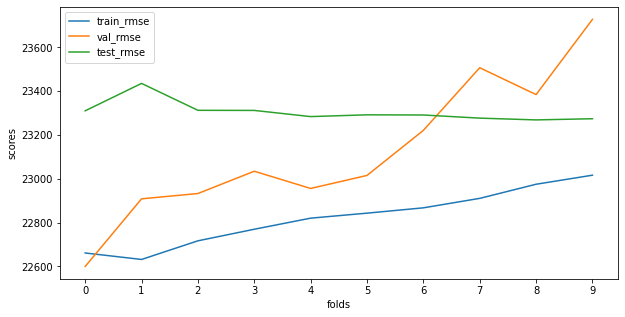

In [7]:
lr = model_training(LinearRegression())

In [8]:
test_flat_types(lr)

1 ROOM: No. of samples = 30, RMSE = 10376.5142, Z-score = 1.11
2 ROOM: No. of samples = 1056, RMSE = 13283.2748, Z-score = 0.46
3 ROOM: No. of samples = 14371, RMSE = 16924.5146, Z-score = 0.31
4 ROOM: No. of samples = 25371, RMSE = 23479.2396, Z-score = 0.26
5 ROOM: No. of samples = 15482, RMSE = 28180.1045, Z-score = 0.26
EXECUTIVE: No. of samples = 4922, RMSE = 33330.3858, Z-score = 0.38
JUMBO: No. of samples = 118, RMSE = 34587.2113, Z-score = 0.32
MULTI-GENERATION: No. of samples = 37, RMSE = 42607.0155, Z-score = 0.71
TERRACE: No. of samples = 39, RMSE = 42004.5322, Z-score = 0.61


Training start...
Fold 1: Train RMSE = 22658.1722, Val RMSE = 22590.8887, Test RMSE = 23240.5683 Time elapsed = 0.049s
Fold 2: Train RMSE = 22628.5256, Val RMSE = 22879.5566, Test RMSE = 23237.2642 Time elapsed = 0.102s
Fold 3: Train RMSE = 22713.5748, Val RMSE = 22927.8718, Test RMSE = 23225.2013 Time elapsed = 0.159s
Fold 4: Train RMSE = 22766.357, Val RMSE = 23008.4521, Test RMSE = 23213.3587 Time elapsed = 0.215s
Fold 5: Train RMSE = 22816.9213, Val RMSE = 22940.8283, Test RMSE = 23203.3041 Time elapsed = 0.269s
Fold 6: Train RMSE = 22839.6913, Val RMSE = 23004.4182, Test RMSE = 23222.3216 Time elapsed = 0.331s
Fold 7: Train RMSE = 22863.951, Val RMSE = 23189.868, Test RMSE = 23219.6092 Time elapsed = 0.388s
Fold 8: Train RMSE = 22907.0822, Val RMSE = 23484.4718, Test RMSE = 23232.3684 Time elapsed = 0.44s
Fold 9: Train RMSE = 22971.5208, Val RMSE = 23368.7738, Test RMSE = 23239.454 Time elapsed = 0.498s
Fold 10: Train RMSE = 23012.7668, Val RMSE = 23709.1319, Test RMSE = 23246.455

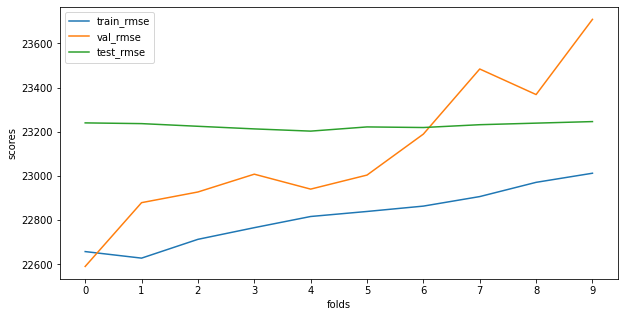

In [9]:
tree = model_training(DecisionTreeRegressor())

In [10]:
test_flat_types(tree)

1 ROOM: No. of samples = 30, RMSE = 10366.5491, Z-score = 1.11
2 ROOM: No. of samples = 1056, RMSE = 13335.7318, Z-score = 0.46
3 ROOM: No. of samples = 14371, RMSE = 16952.4295, Z-score = 0.31
4 ROOM: No. of samples = 25371, RMSE = 23447.0826, Z-score = 0.26
5 ROOM: No. of samples = 15482, RMSE = 28075.1003, Z-score = 0.26
EXECUTIVE: No. of samples = 4922, RMSE = 33283.5264, Z-score = 0.38
JUMBO: No. of samples = 118, RMSE = 34620.7324, Z-score = 0.32
MULTI-GENERATION: No. of samples = 37, RMSE = 42215.279, Z-score = 0.7
TERRACE: No. of samples = 39, RMSE = 42176.3658, Z-score = 0.61


Training start...
Fold 1: Train RMSE = 22657.6809, Val RMSE = 22589.6207, Test RMSE = 23238.2967 Time elapsed = 0.577s
Fold 2: Train RMSE = 22628.1478, Val RMSE = 22882.8827, Test RMSE = 23236.7626 Time elapsed = 1.083s
Fold 3: Train RMSE = 22713.6112, Val RMSE = 22924.4399, Test RMSE = 23222.3101 Time elapsed = 1.48s
Fold 4: Train RMSE = 22765.8417, Val RMSE = 23004.2963, Test RMSE = 23214.008 Time elapsed = 2.243s
Fold 5: Train RMSE = 22816.4663, Val RMSE = 22940.4744, Test RMSE = 23219.6469 Time elapsed = 2.598s
Fold 6: Train RMSE = 22839.5911, Val RMSE = 22994.467, Test RMSE = 23211.6258 Time elapsed = 3.178s
Fold 7: Train RMSE = 22863.5833, Val RMSE = 23189.5832, Test RMSE = 23216.8315 Time elapsed = 3.637s
Fold 8: Train RMSE = 22906.911, Val RMSE = 23480.7805, Test RMSE = 23230.4938 Time elapsed = 4.592s
Fold 9: Train RMSE = 22971.172, Val RMSE = 23358.858, Test RMSE = 23231.4712 Time elapsed = 4.74s
Fold 10: Train RMSE = 23012.4723, Val RMSE = 23704.0122, Test RMSE = 23243.0144 

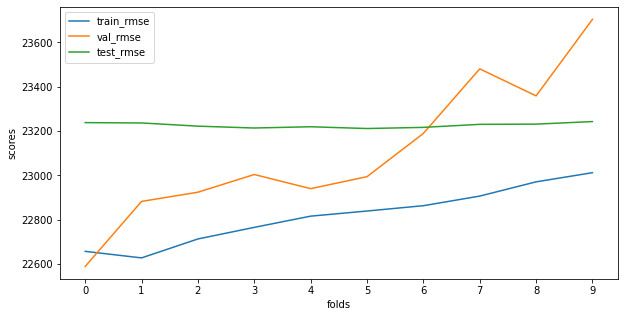

In [11]:
forest = model_training(RandomForestRegressor())

In [12]:
test_flat_types(forest)

1 ROOM: No. of samples = 30, RMSE = 10387.4497, Z-score = 1.11
2 ROOM: No. of samples = 1056, RMSE = 13333.2432, Z-score = 0.46
3 ROOM: No. of samples = 14371, RMSE = 16941.0957, Z-score = 0.31
4 ROOM: No. of samples = 25371, RMSE = 23443.6397, Z-score = 0.26
5 ROOM: No. of samples = 15482, RMSE = 28091.2286, Z-score = 0.26
EXECUTIVE: No. of samples = 4922, RMSE = 33250.0548, Z-score = 0.38
JUMBO: No. of samples = 118, RMSE = 34579.5117, Z-score = 0.32
MULTI-GENERATION: No. of samples = 37, RMSE = 42492.5737, Z-score = 0.71
TERRACE: No. of samples = 39, RMSE = 42211.2263, Z-score = 0.61


Training start...
Fold 1: Train RMSE = 22658.1722, Val RMSE = 22595.6572, Test RMSE = 23237.196 Time elapsed = 0.361s
Fold 2: Train RMSE = 22628.5256, Val RMSE = 22884.2329, Test RMSE = 23223.8756 Time elapsed = 0.7s
Fold 3: Train RMSE = 22713.5748, Val RMSE = 22931.0177, Test RMSE = 23212.0296 Time elapsed = 1.079s
Fold 4: Train RMSE = 22766.357, Val RMSE = 23011.1775, Test RMSE = 23206.345 Time elapsed = 1.489s
Fold 5: Train RMSE = 22816.9213, Val RMSE = 22944.2044, Test RMSE = 23204.4678 Time elapsed = 1.78s
Fold 6: Train RMSE = 22839.6913, Val RMSE = 22998.9111, Test RMSE = 23211.1845 Time elapsed = 2.01s
Fold 7: Train RMSE = 22863.951, Val RMSE = 23198.6546, Test RMSE = 23221.3372 Time elapsed = 2.47s
Fold 8: Train RMSE = 22907.0822, Val RMSE = 23485.2881, Test RMSE = 23231.1486 Time elapsed = 2.745s
Fold 9: Train RMSE = 22971.5208, Val RMSE = 23370.7203, Test RMSE = 23235.3789 Time elapsed = 3.304s
Fold 10: Train RMSE = 23012.7668, Val RMSE = 23711.9438, Test RMSE = 23246.0106 Ti

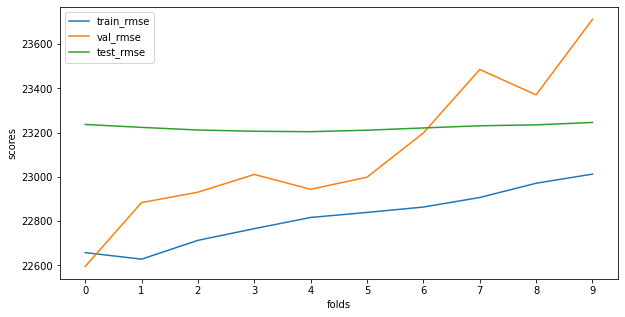

In [13]:
extra_trees = model_training(ExtraTreesRegressor())

In [14]:
test_flat_types(extra_trees)

1 ROOM: No. of samples = 30, RMSE = 10371.439, Z-score = 1.11
2 ROOM: No. of samples = 1056, RMSE = 13326.8128, Z-score = 0.46
3 ROOM: No. of samples = 14371, RMSE = 16932.9971, Z-score = 0.31
4 ROOM: No. of samples = 25371, RMSE = 23460.7407, Z-score = 0.26
5 ROOM: No. of samples = 15482, RMSE = 28086.7074, Z-score = 0.26
EXECUTIVE: No. of samples = 4922, RMSE = 33244.6681, Z-score = 0.38
JUMBO: No. of samples = 118, RMSE = 34566.5722, Z-score = 0.32
MULTI-GENERATION: No. of samples = 37, RMSE = 42627.8679, Z-score = 0.71
TERRACE: No. of samples = 39, RMSE = 42074.773, Z-score = 0.61


Training start...
Fold 1: Train RMSE = 22660.0598, Val RMSE = 22606.1869, Test RMSE = 23230.9973 Time elapsed = 0.94s
Fold 2: Train RMSE = 22630.5305, Val RMSE = 22891.3791, Test RMSE = 23229.0997 Time elapsed = 1.857s
Fold 3: Train RMSE = 22715.6479, Val RMSE = 22928.5422, Test RMSE = 23226.1181 Time elapsed = 2.737s
Fold 4: Train RMSE = 22768.5427, Val RMSE = 23016.5165, Test RMSE = 23226.2085 Time elapsed = 3.627s
Fold 5: Train RMSE = 22819.1818, Val RMSE = 22946.6093, Test RMSE = 23229.1777 Time elapsed = 4.488s
Fold 6: Train RMSE = 22842.0149, Val RMSE = 23002.9385, Test RMSE = 23229.3994 Time elapsed = 5.381s
Fold 7: Train RMSE = 22866.3592, Val RMSE = 23210.718, Test RMSE = 23237.0925 Time elapsed = 6.23s
Fold 8: Train RMSE = 22909.5849, Val RMSE = 23492.2317, Test RMSE = 23242.3318 Time elapsed = 7.101s
Fold 9: Train RMSE = 22974.1215, Val RMSE = 23375.1058, Test RMSE = 23244.9431 Time elapsed = 7.995s
Fold 10: Train RMSE = 23015.4495, Val RMSE = 23714.0769, Test RMSE = 23249.3

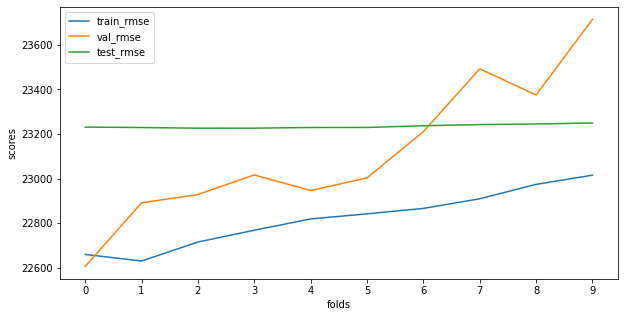

In [15]:
xgb = model_training(GradientBoostingRegressor(
    random_state=42
))

In [16]:
test_flat_types(xgb)

1 ROOM: No. of samples = 30, RMSE = 10297.4099, Z-score = 1.1
2 ROOM: No. of samples = 1056, RMSE = 13258.3082, Z-score = 0.46
3 ROOM: No. of samples = 14371, RMSE = 16908.9491, Z-score = 0.31
4 ROOM: No. of samples = 25371, RMSE = 23461.5382, Z-score = 0.26
5 ROOM: No. of samples = 15482, RMSE = 28125.9151, Z-score = 0.26
EXECUTIVE: No. of samples = 4922, RMSE = 33310.9165, Z-score = 0.38
JUMBO: No. of samples = 118, RMSE = 34654.7586, Z-score = 0.32
MULTI-GENERATION: No. of samples = 37, RMSE = 42809.5208, Z-score = 0.71
TERRACE: No. of samples = 39, RMSE = 42424.4499, Z-score = 0.61


In [21]:
models = [xgb, extra_trees, lr, tree, forest]

results = []
for model in models:
    print(model)
    y_true = y_test
    y_pred = np.log1p(model.predict(X_test))
    rmse = np.exp(mean_squared_error(y_true, y_pred, squared=False)).round(4)
    results.append(rmse)
    print(rmse)

print("Ensemble results:", np.mean(results).round(4))

GradientBoostingRegressor(random_state=42)
23249.3114
ExtraTreesRegressor()
23246.0106
LinearRegression()
23274.5141
DecisionTreeRegressor()
23246.4558
RandomForestRegressor()
23243.0144
Ensemble results: 23251.8613


In [18]:
# # Save model
# filename = 'forest_model.sav'
# joblib.dump(forest, filename)

In [19]:
# # Load model
# path = os.path.join("", filename)
# load_model = joblib.load(path)
# result = load_model.score(X_test, y_test)
# print(result)